In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn
from Fitting import fit_for_all_subjects

sys.path.append("../functions")

from Utility import *
from Plotting import *

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Reading the Data

In [2]:
# reading raw data
working_dir = "/ptmp/agholamzadeh/"
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
chance_level_subs = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subs))
]
hv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "lc1")
    & (~data["sub"].isin(chance_level_subs))
]
lv_test_data = data[
    (data["phase"] == "test")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subs))
]
hv_test_data = data[
    (data["phase"] == "test")
    & (data["condition"] == "lc1")
    & (~data["sub"].isin(chance_level_subs))
]

subjects = lv_induction_data["sub"].unique()

data_list = [lv_induction_data, hv_induction_data, lv_test_data, hv_test_data]
data_list_names = ["lv_induction", "hv_induction", "lv_test", "hv_test"]

## Fitting

In [30]:
from Forward import forward_fitting

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
forward_dfs = []
n_fitting = 120
n_threads = 8
for data in data_list:
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, data, forward_fitting
    )
    forward_df = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )
    forward_df["hbound"] = (5 - forward_df["lbound"]) * (
        forward_df["bound_range"]
    ) + forward_df["lbound"]
    forward_dfs.append(forward_df)

In [17]:
from Backward import backward_fitting

params_ranges = [[0, 1], [0, 100], [1, 5], [0.001, 1]]
n_fitting = 120
backward_dfs = []
for data in data_list:
    back_res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, data, backward_fitting
    )
    backward_df = make_df_after_fitting(
        back_res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )
    backward_df["hbound"] = (5 - backward_df["lbound"]) * (
        backward_df["bound_range"]
    ) + backward_df["lbound"]
    backward_dfs.append(backward_df)

## Simulation with fitted parameters

In [31]:
from Forward import simulate_with_params

np.random.seed(1)
forward_simulation_dfs = []
backward_simulation_dfs = []
for forward_df, data in zip(forward_dfs, data_list):
    forward_simulation_df = simulate_with_params(forward_df, data, subjects)
    forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
    forward_simulation_dfs.append(forward_simulation_df)

for backward_df, data in zip(backward_dfs, data_list):
    backward_simulation_df = simulate_with_params(backward_df, data, subjects)
    backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
    backward_simulation_dfs.append(backward_simulation_df)

In [ ]:
forward_avg_dfs = []
for forward_simulation_df, data in zip(forward_simulation_dfs, data_list):
    forward_avg_df = (
        forward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    emp_avg_df = data.rename(columns={"sub": "subject"})
    emp_avg_df = (
        emp_avg_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    forward_avg_df.rename(
        columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
        inplace=True,
    )
    forward_avg_df = pd.merge(forward_avg_df, emp_avg_df, on=["subject"])

    forward_avg_df["fwd_emp"] = forward_avg_df["accuracy"] - forward_avg_df["cor"]
    forward_avg_dfs.append(forward_avg_df)

groups = ["lv_induction", "hv_induction", "lv_test", "hv_test"]
df = merge_result_df(forward_avg_dfs, groups, 200, subjects)

Statistics=125.0, p=1.05588169887459e-07
Statistics=280.0, p=6.827286304734016e-05
Statistics=396.0, p=0.002847699801274938


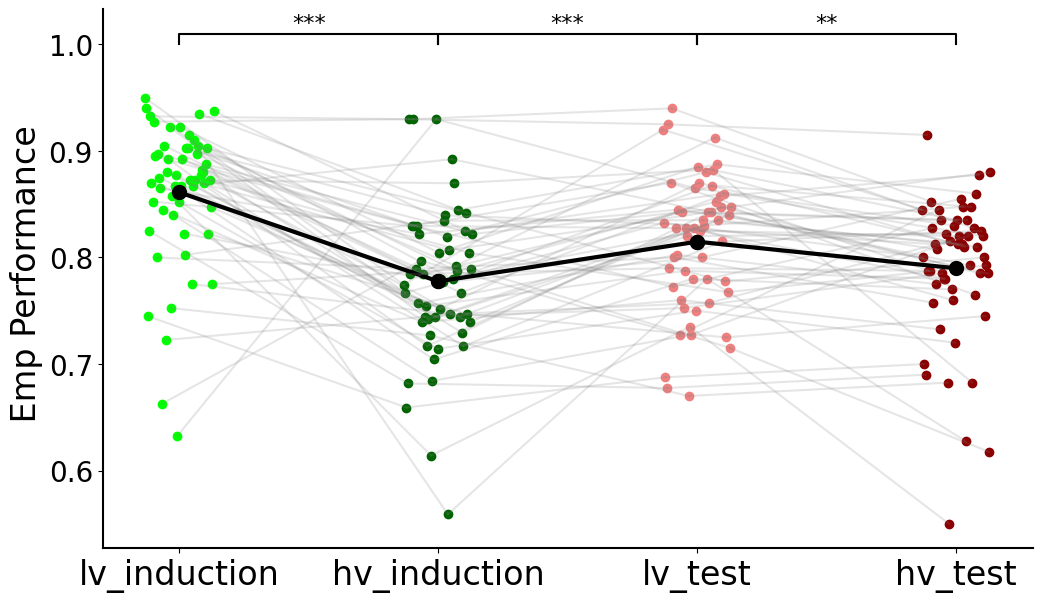

In [8]:
groups = ["lv_induction", "hv_induction", "lv_test", "hv_test"]

plt.figure(figsize=(12, 7))

comparison_plot(
    df,
    "cor",
    groups,
    "",
    [
        ["lv_induction", "hv_induction"],
        ["hv_induction", "lv_test"],
        ["lv_test", "hv_test"],
    ],
    [1, 1, 1],
    [0.01, 0.01, 0.01],
    y_label=" Emp Performance",
)

Statistics=55.0, p=3.2281917037064916e-09
Statistics=705.0, p=0.74678371893104
Statistics=594.5, p=0.2840605235319644


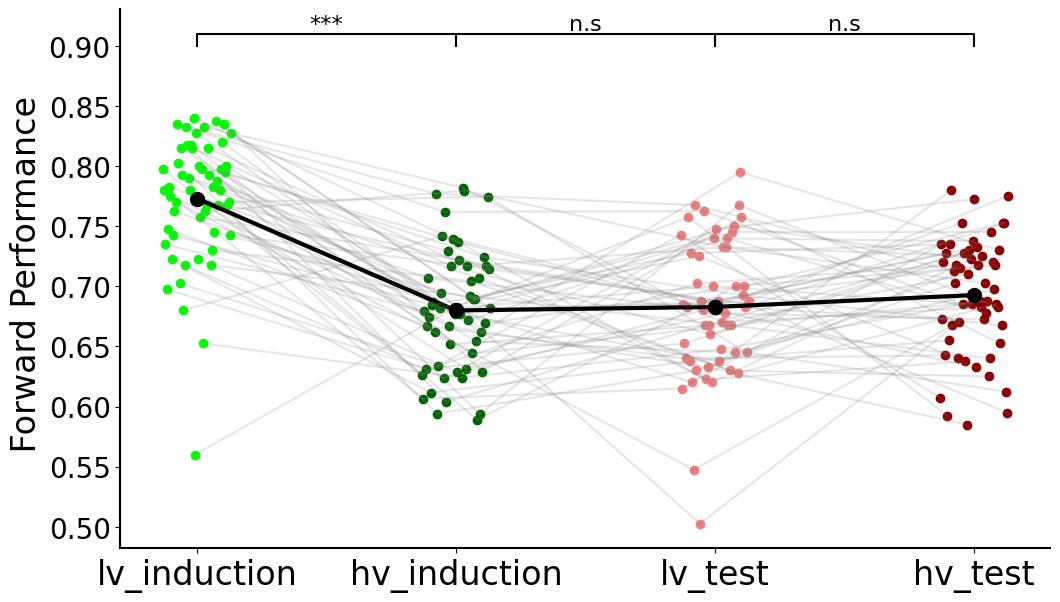

In [10]:
plt.figure(figsize=(12, 7))

comparison_plot(
    df,
    "accuracy",
    groups,
    "",
    [
        ["lv_induction", "hv_induction"],
        ["hv_induction", "lv_test"],
        ["lv_test", "hv_test"],
    ],
    [0.9, 0.9, 0.9],
    [0.01, 0.01, 0.01],
    y_label=" Forward Performance",
)

Statistics=630.0, p=0.3327200846236221
Statistics=479.0, p=0.023280950802458164
Statistics=396.0, p=0.0028498879077197272


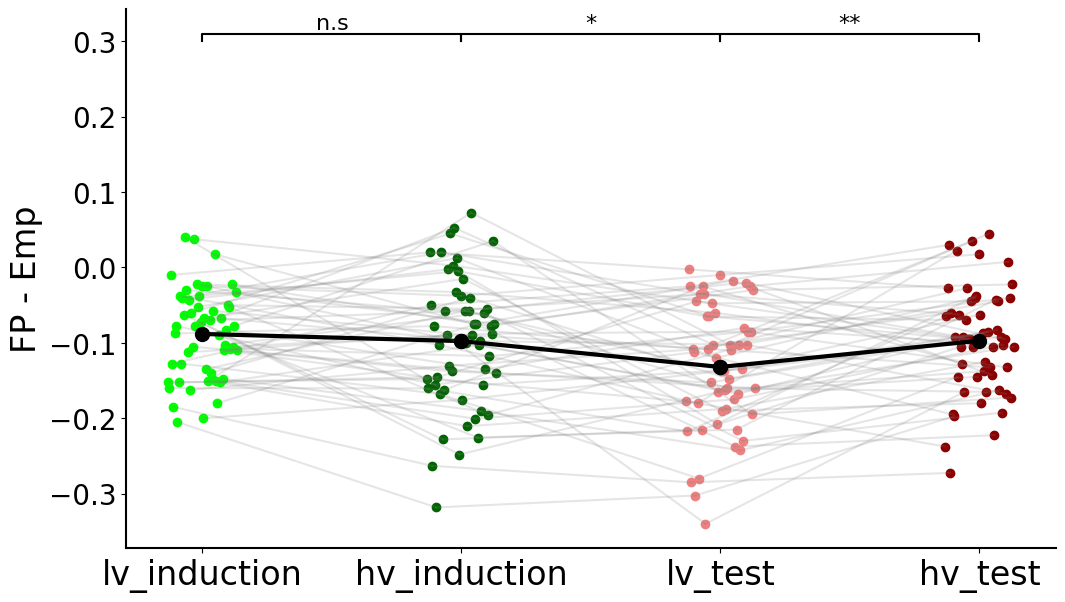

In [12]:
plt.figure(figsize=(12, 7))

comparison_plot(
    df,
    "fwd_emp",
    groups,
    "",
    [
        ["lv_induction", "hv_induction"],
        ["hv_induction", "lv_test"],
        ["lv_test", "hv_test"],
    ],
    [0.3, 0.3, 0.3],
    [0.01, 0.01, 0.01],
    y_label="FP - Emp",
)

In [25]:
backward_avg_dfs = []
for backward_simulation_df, data in zip(backward_simulation_dfs, data_list):
    backward_avg_df = (
        backward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    emp_avg_df = data.rename(columns={"sub": "subject"})
    emp_avg_df = (
        emp_avg_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    backward_avg_df.rename(
        columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
        inplace=True,
    )
    backward_avg_df = pd.merge(backward_avg_df, emp_avg_df, on=["subject"])

    backward_avg_df["fwd_emp"] = backward_avg_df["accuracy"] - backward_avg_df["cor"]
    backward_avg_dfs.append(backward_avg_df)

groups = ["lv_induction", "hv_induction", "lv_test", "hv_test"]
df = merge_result_df(backward_avg_dfs, groups, 200, subjects)

Statistics=237.0, p=1.3461524641046846e-05
Statistics=573.0, p=0.1444462574846871
Statistics=519.0, p=0.17706778272769963


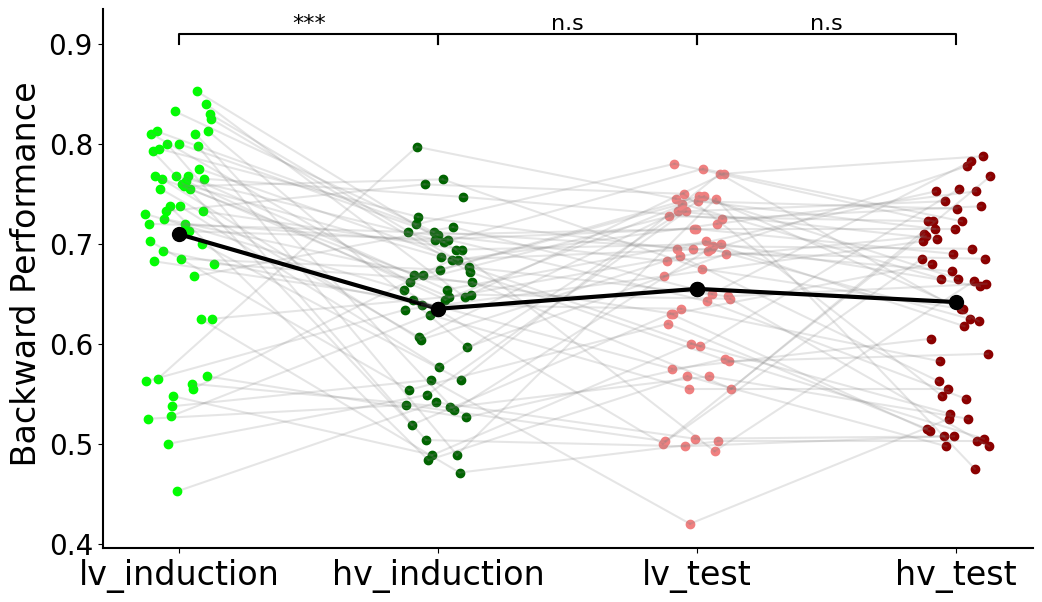

In [27]:
plt.figure(figsize=(12, 7))

comparison_plot(
    df,
    "accuracy",
    groups,
    "",
    [
        ["lv_induction", "hv_induction"],
        ["hv_induction", "lv_test"],
        ["lv_test", "hv_test"],
    ],
    [0.9, 0.9, 0.9],
    [0.01, 0.01, 0.01],
    y_label=" Backward Performance",
)

Statistics=691.0, p=0.6574544974929585
Statistics=678.0, p=0.5786490889310159
Statistics=672.0, p=0.5438168613185395


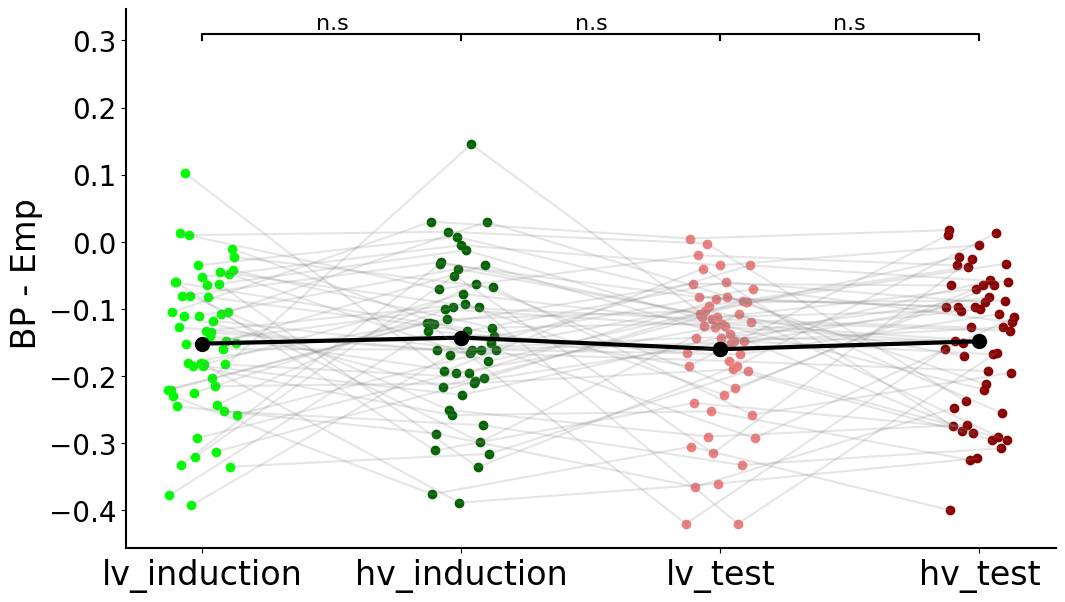

In [29]:
plt.figure(figsize=(12, 7))

comparison_plot(
    df,
    "fwd_emp",
    groups,
    "",
    [
        ["lv_induction", "hv_induction"],
        ["hv_induction", "lv_test"],
        ["lv_test", "hv_test"],
    ],
    [0.3, 0.3, 0.3],
    [0.01, 0.01, 0.01],
    y_label=" BP - Emp",
)

In [35]:
dfs = []
for backward_simulation_df, forward_simulation_df in zip(
    backward_simulation_dfs, forward_simulation_dfs
):
    backward_avg_df = (
        backward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    forward_avg_df = (
        forward_simulation_df.groupby("subject")
        .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
        .reset_index()
    )

    backward_avg_df.rename(
        columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
        inplace=True,
    )
    backward_avg_df = pd.merge(backward_avg_df, forward_avg_df, on=["subject"])

    backward_avg_df["mrl_ratio"] = backward_avg_df["accuracy"] / backward_avg_df["cor"]
    dfs.append(backward_avg_df)

groups = ["lv_induction", "hv_induction", "lv_test", "hv_test"]
df = merge_result_df(dfs, groups, 200, subjects)

Statistics=614.0, p=0.2685477958054685
Statistics=694.0, p=0.6762428341856406
Statistics=633.0, p=0.34577355774228435


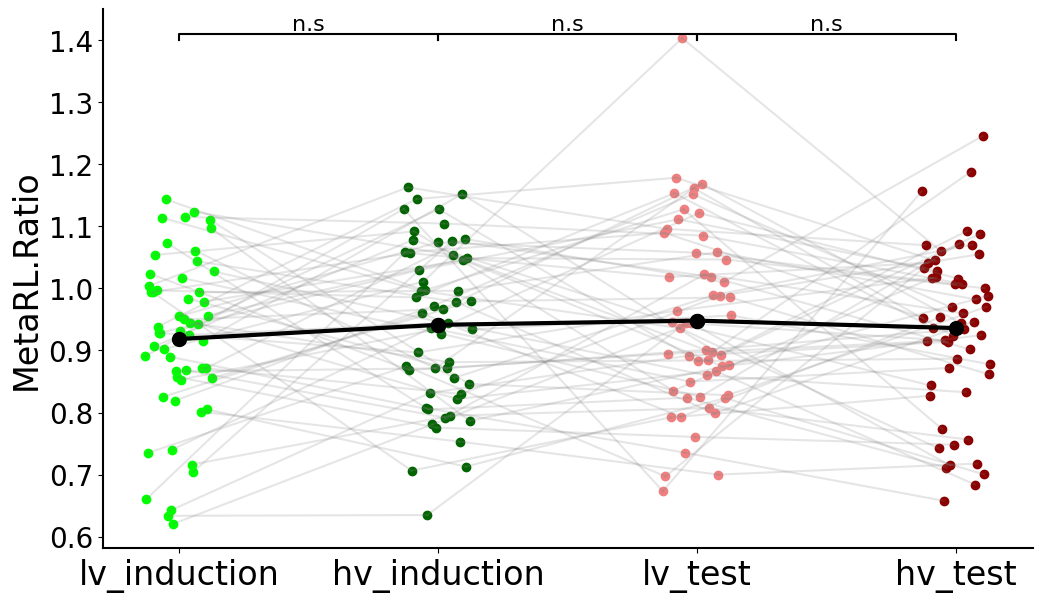

In [37]:
plt.figure(figsize=(12, 7))

comparison_plot(
    df,
    "mrl_ratio",
    groups,
    "",
    [
        ["lv_induction", "hv_induction"],
        ["hv_induction", "lv_test"],
        ["lv_test", "hv_test"],
    ],
    [1.4, 1.4, 1.4],
    [0.01, 0.01, 0.01],
    y_label="MetaRL.Ratio",
)